Copyright ENEOS corporation as contributors to Matlantis contrib project

# Notebook1_分子の準備・構造最適化
本NotebookはMatlantisチュートリアル"1_Welcome.ipynb"を一部改変し、ASEの使用方法に重点を置いたものです。  

# 目次
[計算ファイルの準備](#計算ファイルの準備)    
[分子構造の生成](#分子構造の生成)  
[(1)ASEのデータベースから取得](#(1)ASEのデータベースから取得)  
[(2)PubChemから取得](#(2)PubChemから取得)  
[(3) 分子構造ファイルの入出力](#(3)分子構造ファイルの入出力)  
[(4)直接指定](#(4)直接指定)  
[分子の可視化](#分子の可視化)  
[分子の計算](#分子の計算)  
[calculatorの設定](#calculatorの設定)  
[構造最適化とエネルギー出力](#構造最適化とエネルギー出力)  
[Tips:Atomsオブジェクトについて](#Tips:Atomsオブジェクトについて)

# 計算ファイルの準備
## 分子構造の作成

ASEでは、シミュレーションを行う対象は`Atoms`クラスのオブジェクトとして管理されます(`Atoms`については[Notebook2のTips](../for_b2/for_b2.ipynb)にて説明いたします)。  
ASEでは非常に多くの種類のファイルの入出力に対応しています。詳細は[ASE ioリファレンス](https://wiki.fysik.dtu.dk/ase/ase/io/io.html)をご参照ください。  
ここではASE標準で搭載されている、4種類の方法について解説します。

## (1)ASEのデータベースから取得  
ASEデータベースに存在する分子は以下のように取得可能です。

In [1]:
from ase.build import molecule
EtMeEther = molecule("CH3CH2OCH3")
print(EtMeEther.get_chemical_symbols())

['O', 'C', 'C', 'C', 'H', 'H', 'H', 'H', 'H', 'H', 'H', 'H']


In [2]:
h2o_molecule = molecule('H2O')
print(h2o_molecule)

Atoms(symbols='OH2', pbc=False)


## (2)PubChemから取得
[PubChem](https://pubchem.ncbi.nlm.nih.gov/)に登録されている分子も同様に、CID、SMILES形式などで取得可能です。

In [3]:
from ase.data.pubchem import pubchem_atoms_search, pubchem_atoms_conformer_search
benzene = pubchem_atoms_search(cid=241)
ethanol = pubchem_atoms_search(smiles='CCOH')

## (3) 分子構造ファイルの入出力
ASEではこれらの分子構造をcifやxyzなど、多様なファイル形式で入出力可能です。

In [5]:
import os
from ase.io import read, write
os.makedirs("output/", exist_ok=True)
write("output/EthylMethylEther.xyz",EtMeEther) #atomsに格納されている分子構造をxyz形式で書き出し
EtMeEther = read("output/EthylMethylEther.xyz")

## (4)直接指定
元素の種類、個数のCartesian座標を直接指定して分子を作成することも可能です。

In [6]:
import numpy as np
import ase
from ase import Atoms, units
lattice_constant = 5.43

atoms = ase.Atoms(
    symbols=["Si"] * 8,
    positions = lattice_constant * np.array([
        [0.0, 0.0, 0.0],
        [0.0, 0.5, 0.5],
        [0.5, 0.0, 0.5],
        [0.5, 0.5, 0.0],
        [0.25, 0.25, 0.25],
        [0.25, 0.75, 0.75],
        [0.75, 0.25, 0.75],
        [0.75, 0.75, 0.25],
    ]),
    cell=[lattice_constant] * 3,
    pbc=True,
)

# 分子の可視化  
Matlantisではいくつかの可視化ツールをプリインストールしています。ここではnglviewerを使います。  
作成した分子は以下のように可視化できます。マウスで操作でき、ドラッグで回転、原子をクリックで対象の原子を中央に移動します。  
見た目をカスタマイズすることもできます。詳細は[ASEリファレンス](https://wiki.fysik.dtu.dk/ase/ase/visualize/visualize.html)を参照してください。

In [7]:
from ase.visualize import view
v = view(EtMeEther, viewer='ngl')
v.view.add_representation("ball+stick") #見た目のカスタマイズ
display(v)

分子描画をpng形式などで保存することも可能です。

In [8]:
ase.io.write("output/EthylMethylEther.png",EtMeEther)

## 分子の計算
### calculatorの設定
分子のエネルギー計算を行う`calculator`の設定は以下のように行います。  
PFPの本体は`Estimator`というクラスで定義されています。    
`Estimator`をASEの`Atoms`(計算対象分子)に適用するためのクラスが`ASECalculator`です。  
以下のように準備を行うことでポテンシャルの利用が可能です。  

In [9]:
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from pfp_api_client.pfp.estimator import Estimator
estimator = Estimator(model_version='v2.0.0') # versionを指定することを推奨します
calculator = ASECalculator(estimator)
EtMeEther.calc = calculator                   # 分子にcalculatorを設定

Atomsにcalculatorを設定すると、以下のようにエネルギーや力などの各種物性値が計算できるようになります。

In [10]:
print("Energy: {}".format(EtMeEther.get_potential_energy()))
print(EtMeEther.get_forces())

Energy: -48.05970493552741
[[ 6.73275581e-02 -9.94712561e-02 -4.21309391e-08]
 [-2.98680980e-01  2.49483697e-02  1.62161398e-07]
 [-1.22649611e-01 -1.06074420e-01  1.92461606e-07]
 [ 1.18141652e-01  6.28063531e-02 -8.00305029e-07]
 [ 1.24601755e-01  6.29219928e-02  1.89003746e-01]
 [ 1.24601869e-01  6.29212913e-02 -1.89003651e-01]
 [ 2.47332199e-02 -2.08312401e-01  8.61693910e-08]
 [ 1.33233319e-01  6.12520802e-02 -1.88249056e-01]
 [ 1.33234126e-01  6.12512369e-02  1.88248950e-01]
 [-1.40087761e-01 -4.09320610e-02 -1.73115117e-01]
 [-1.40087508e-01 -4.09330714e-02  1.73115693e-01]
 [-2.43676403e-02  1.59621885e-01 -1.63014393e-07]]


## 構造最適化計算とエネルギー出力
設定したcalculatorを使用して分子の構造最適化を行います。  
ここではBFGS法という手法を用いて構造最適化します。

      Step     Time          Energy         fmax
BFGS:    0 00:48:20      -48.059705        0.2997
BFGS:    1 00:48:20      -48.064715        0.1636
BFGS:    2 00:48:21      -48.066915        0.1303
BFGS:    3 00:48:21      -48.067979        0.0731
BFGS:    4 00:48:21      -48.068503        0.0639
BFGS:    5 00:48:21      -48.069237        0.0624
BFGS:    6 00:48:22      -48.069870        0.0756
BFGS:    7 00:48:22      -48.070470        0.0587
BFGS:    8 00:48:22      -48.070867        0.0610
BFGS:    9 00:48:22      -48.071070        0.0386


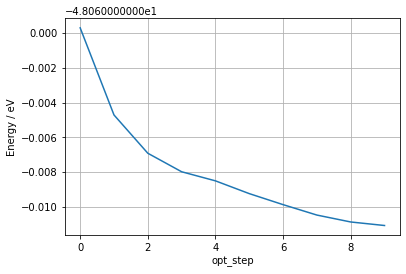

In [11]:
from ase.optimize import BFGS
from ase.io import Trajectory
import matplotlib.pyplot as plt
opt = BFGS(EtMeEther,trajectory="output/bfgs.traj")     # 最適化ログをbfgs.trajに保存
opt.run()
opt_step = Trajectory("output/bfgs.traj")               # 以下は最適化ログの可視化
energies = [step.get_total_energy() for step in opt_step]
plt.plot(range(len(energies)),energies)
plt.grid(True)
plt.xlabel("opt_step")
plt.ylabel("Energy / eV")
plt.show()

最適化のログはトラジェクトリ(bfgs.traj)として保存しています。  
最適化の過程で”EtMeEther”の構造は逐次更新されています。  
※PFPではエネルギーをeVで返します。  
※1 eV = 96.485 kJ mol^-1 = 23.06 kcal mol^-1 

# Tips : Trajectryオブジェクトについて  
Trajectoryオブジェクトには複数のAtomsオブジェクトが格納されています。  
格納されている構造情報はインデックスを指定して取り出すことやまとめて可視化することができます。

In [12]:
IS= opt_step[0] #optstep(trajectryオブジェクト)の初期構造を取り出す

可視化の際には軌跡を再生することができます。
軌跡の動画をgifなどの形式で保存することも可能です。

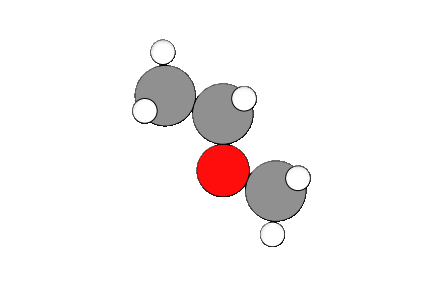

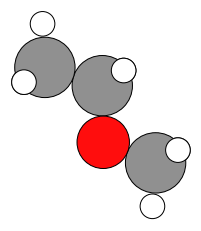

In [13]:
from IPython.display import Image
ase.io.write("output/opt_step.gif", opt_step, format="gif")
Image(data=open("output/opt_step.gif", "rb").read(), format='gif') #GIFをNotebook内で表示

また、Trajectryオブジェクトを活用することでNEB計算を簡単に実行できます。